In [1]:
! pip install session_info

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 63 kB 837 kB/s 
  Created wheel for session-info: filename=session_info-1.0.0-py3-none-any.whl size=8048 sha256=399fa217957974ba419d1c80a663a6ad086dddca367bc2219ca6d57986fd855c
  Stored in directory: /root/.cache/pip/wheels/bd/ad/14/6a42359351a18337a8683854cfbba99dd782271f2d1767f87f
Successfully built session-info


In [2]:
! pip install gensim==3.8.3

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 24.2 MB 1.6 MB/s 
  Attempting uninstall: gensim
    Found existing installation: gensim 3.6.0
    Uninstalling gensim-3.6.0:
      Successfully uninstalled gensim-3.6.0


In [3]:
import nltk
import re
import session_info

import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from nltk.stem.wordnet import WordNetLemmatizer
from gensim.models import Word2Vec
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

from nltk.corpus import stopwords

In [4]:
session_info.show()

## Note

The [class GitHub repo](https://github.com/djp840/MSDS_453_Public) uses `gensim == 3.8.3`. This version of gensim will not install on Python versions 3.9+ (tested on Windows).

The latest version of `gensim == 4.2.0`.

# Data

In [5]:
data_file = 'DSP453_ClassCorpus_v1.csv'

In [6]:
class_corpus = pd.read_csv(data_file)

In [7]:
class_corpus.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 8 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Doc_ID                    100 non-null    int64 
 1   DSI_Title                 100 non-null    object
 2   Text                      100 non-null    object
 3   Submission File Name      100 non-null    object
 4   Student Name              100 non-null    object
 5   Genre of Movie            100 non-null    object
 6   Review Type (pos or neg)  100 non-null    object
 7   Movie Title               100 non-null    object
dtypes: int64(1), object(7)
memory usage: 6.4+ KB


# Executing Experiments

In this section, we present an end-to-end execution of one experiment for the three methods of vectorization:

- TF-IDF
- Word2Vec
- Doc2vec

A prerequisite for each of these vectorization methods is the choice of data wrangling method. Hence, we begin by executing one particular data wrangling procedure detailed in the next section (this is the same method we used in the previous notebook).

## Data Wrangling

In [8]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [9]:
STOP_WORDS = set(nltk.corpus.stopwords.words('english'))

In [10]:
def remove_punctuation(text):
    return re.sub('[^a-zA-Z]', ' ', str(text))

def lower_case(text):
    return text.lower()    

def remove_tags(text):    
    return re.sub("&lt;/?.*?&gt;"," &lt;&gt; ", text)

def remove_special_chars_and_digits(text):
    return re.sub("(\\d|\\W)+"," ", text)

def remove_stop_words(tokenized_text):
    return [w for w in tokenized_text if not w in STOP_WORDS]

In [11]:
def normalize(input_text):
    '''
    Normalization involves the following steps:
    1. Remove punctuation
    2. Lower case all words
    3. Remove tags (i.e., HTML tags)
    4. Remove all special characters and digits
    '''
    text = remove_punctuation(input_text)
    text = lower_case(text)
    text = remove_tags(text)
    text = remove_special_chars_and_digits(text)

    return text

In [12]:
def tokenize(text):
    '''
    Tokenization involves the following steps:
    1. Break text down to tokens (i.e., words separated by white spaces)
    2. Remove stop words from the tokens generated in step 1
    '''
    tokens = nltk.word_tokenize(text)
    tokenized_text = remove_stop_words(tokens)
    
    return tokenized_text

In [13]:
def lemmatize(tokenized_text, lemmatizer=WordNetLemmatizer()):
    '''
    Lemmatization is applied to each word in the list of normalized tokens
    (stop words are removed)
    '''
    return [lemmatizer.lemmatize(word) for word in tokenized_text]

In [14]:
def join_tokens(lemmatized_tokens):
    return ' '.join(lemmatized_tokens)

In [16]:
class_corpus['normalized_review'] = class_corpus['Text'].apply(normalize)
class_corpus['tokenized_review'] = class_corpus['normalized_review'].apply(tokenize)
class_corpus['lemmatized_tokens'] = class_corpus['tokenized_review'].apply(lemmatize)
class_corpus['lemmatized_text'] = class_corpus['lemmatized_tokens'].apply(join_tokens)

In [17]:
class_corpus.head()

,Doc_ID,DSI_Title,Text,Submission File Name,Student Name,Genre of Movie,Review Type (pos or neg),Movie Title,normalized_review,tokenized_review,lemmatized_tokens,lemmatized_text
0,101,HBW_Doc1_HolmesAndWatson,"""Holmes and Watson review: a lumbering Sherloc...",HBW_Doc1_HolmesAndWatson,HBW,Comedy,Negative,Holmes and Watson,holmes and watson review a lumbering sherlock...,"[holmes, watson, review, lumbering, sherlockia...","[holmes, watson, review, lumbering, sherlockia...",holmes watson review lumbering sherlockian kno...
1,102,HBW_Doc2_HolmesAndWatson,"""ï¿½Holmes & Watsonï¿½ Review: No, Sh-t Sherlo...",HBW_Doc2_HolmesAndWatson,HBW,Comedy,Negative,Holmes and Watson,holmes watson review no sh t sherlock this wi...,"[holmes, watson, review, sh, sherlock, ferrell...","[holmes, watson, review, sh, sherlock, ferrell...",holmes watson review sh sherlock ferrell john ...
2,103,HBW_Doc3_HolmesAndWatson,"""It is often said that Sherlock Holmes, the le...",HBW_Doc3_HolmesAndWatson,HBW,Comedy,Negative,Holmes and Watson,it is often said that sherlock holmes the leg...,"[often, said, sherlock, holmes, legendary, det...","[often, said, sherlock, holmes, legendary, det...",often said sherlock holmes legendary detective...
3,104,HBW_Doc4_HolmesAndWatson,"""Holmes & Watson wasnï¿½t shown at all to the ...",HBW_Doc4_HolmesAndWatson,HBW,Comedy,Negative,Holmes and Watson,holmes watson wasn t shown at all to the pres...,"[holmes, watson, shown, press, advance, releas...","[holmes, watson, shown, press, advance, releas...",holmes watson shown press advance release one ...
4,105,HBW_Doc5_HolmesAndWatson,"""ï¿½Holmes & Watsonï¿½ Review: Will Ferrell an...",HBW_Doc5_HolmesAndWatson,HBW,Comedy,Negative,Holmes and Watson,holmes watson review will ferrell and john c ...,"[holmes, watson, review, ferrell, john, c, rei...","[holmes, watson, review, ferrell, john, c, rei...",holmes watson review ferrell john c reilly fai...


## TF-IDF

Each TF-IDF experiment is an analysis of the outcome of changing the data wrangling method. Each data wrangling method produces a different set of tokens, and hence a different set of TF-IDF scores. 

In this section, we present the execution of one example TF-IDF experiment on the class corpus using the data wrangling method presented in the previous section.

TF-IDF vectorization is implemented in scikit-learn as the [`TfidfVectorizer`](https://scikit-learn.org/stable/modules/feature_extraction.html#tfidf-term-weighting) class.

In [18]:
tfidf_vectorizer = TfidfVectorizer()

In [19]:
dtm_class_corpus = tfidf_vectorizer.fit_transform(class_corpus['lemmatized_text'])

In [20]:
tfidf_scores_class_corpus = pd.DataFrame(dtm_class_corpus.toarray(), 
                                         columns=tfidf_vectorizer.get_feature_names_out(), 
                                         index=class_corpus.index)

In [21]:
tfidf_scores_class_corpus.head()

,aaannyway,abandon,abandoned,abc,abduct,abducted,abductor,abel,aberration,ability,...,zimmer,zippier,zipping,zippo,zoey,zombie,zombified,zone,zoolander,zora
0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.054497,0.0,0.0
1,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
2,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
3,0.0,0.0,0.038854,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
4,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0


The top 10 TF-IDF scores can now be extracted using the mean TF-IDF scores across all the documents for each term (token).

In [22]:
(tfidf_scores_class_corpus.mean()
                          .sort_values(ascending=False)
                          .head(10))

movie     0.065165
film      0.062151
bond      0.048993
one       0.041121
time      0.034803
holmes    0.034290
like      0.031696
get       0.028622
peele     0.026231
toxic     0.024836
dtype: float64

Another way of thinking of the TF-IDF matrix derived above is to think of each document embedded in the vocabulary space with the coordinates being the TF-IDF scores. With this conceptualization, we could compute the similarity between the documents in the vocabulary space. 

Note that when working with text, we always compute cosine similarity as the default since it is tolerant to scale change.

In [23]:
similarities = cosine_similarity(tfidf_scores_class_corpus, 
                                 tfidf_scores_class_corpus)

We can now plot a heatmap with these similarity values and interpret the patterns we see in the heatmap.

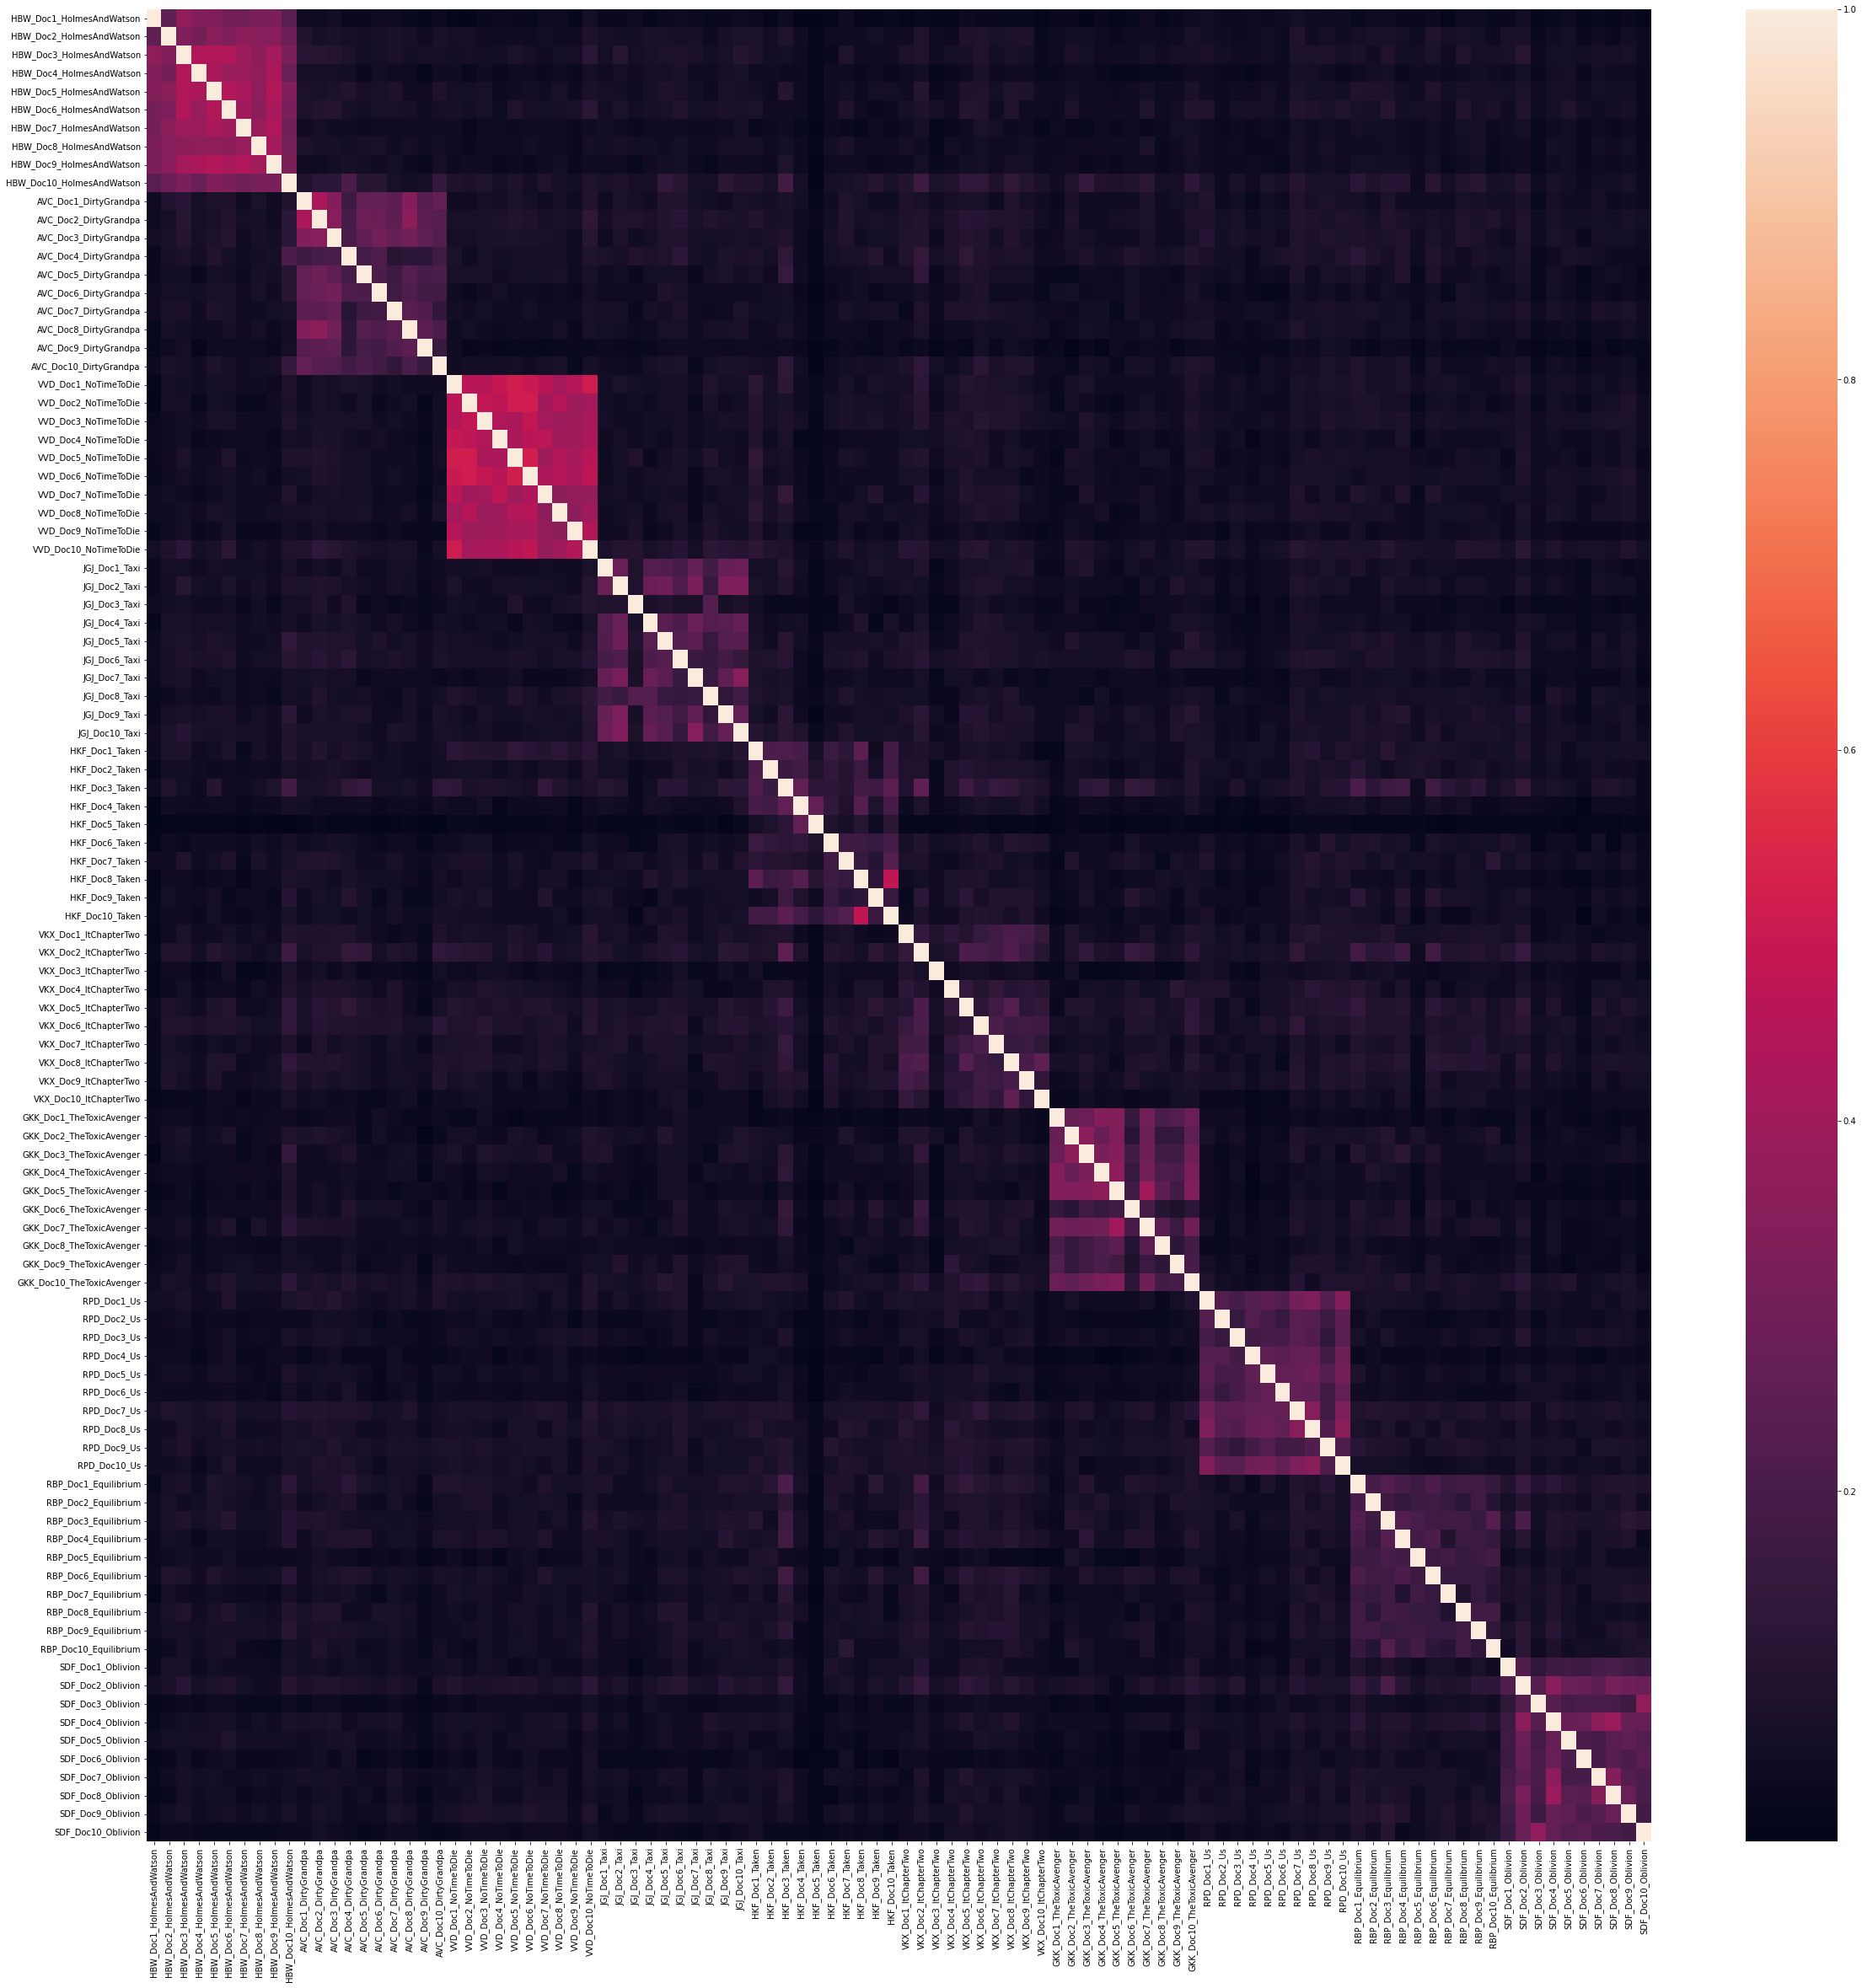

In [25]:
fig, ax = plt.subplots(figsize=(40, 40))

sns.heatmap(ax=ax, 
            data=similarities,
            xticklabels=class_corpus.DSI_Title, 
            yticklabels=class_corpus.DSI_Title)

## Word2Vec

Each `word2vec` experiment is an analysis of the outcomes of changing:
1. The data wrangling method
2. The dimensionality of the word vectors (suggested: 100, 200, 300)

Let us discuss each of these steps one by one.

In order to make our analysis tractable, we focus only on the top 100 tokens by TF-IDF score. Hence, our vocabulary is now reduced to 100 words.

In [26]:
top100_tokens_tfidf = (tfidf_scores_class_corpus.mean()
                                                .sort_values(ascending=False)
                                                .head(100)
                                                .index)

In [27]:
top100_tokens_tfidf

Index(['movie', 'film', 'bond', 'one', 'time', 'holmes', 'like', 'get',
       'peele', 'toxic', 'scene', 'even', 'good', 'character', 'watson',
       'story', 'make', 'ferrell', 'way', 'would', 'much', 'craig', 'action',
       'comedy', 'avenger', 'thing', 'really', 'also', 'taxi', 'go', 'great',
       'grandpa', 'first', 'people', 'daughter', 'well', 'could', 'oblivion',
       'life', 'year', 'niro', 'take', 'world', 'die', 'de', 'see', 'horror',
       'come', 'dirty', 'bad', 'new', 'feel', 'think', 'many', 'two', 'troma',
       'work', 'family', 'reilly', 'james', 'find', 'still', 'fallon', 'never',
       'know', 'little', 'jason', 'made', 'plot', 'jack', 'liam', 'kid', 'say',
       'point', 'may', 'girl', 'going', 'back', 'end', 'child', 'want',
       'something', 'lot', 'old', 'better', 'set', 'best', 'sense', 'part',
       'war', 'actually', 'big', 'though', 'enough', 'funny', 'watch',
       'latifah', 'actor', 'emotion', 'give'],
      dtype='object')

Recall that the class corpus has a series of columns that are a result of a particular choice of data wrangling method. The tokens for each document are the input to our Word2Vec analysis.

In [28]:
class_corpus.head()

,Doc_ID,DSI_Title,Text,Submission File Name,Student Name,Genre of Movie,Review Type (pos or neg),Movie Title,normalized_review,tokenized_review,lemmatized_tokens,lemmatized_text
0,101,HBW_Doc1_HolmesAndWatson,"""Holmes and Watson review: a lumbering Sherloc...",HBW_Doc1_HolmesAndWatson,HBW,Comedy,Negative,Holmes and Watson,holmes and watson review a lumbering sherlock...,"[holmes, watson, review, lumbering, sherlockia...","[holmes, watson, review, lumbering, sherlockia...",holmes watson review lumbering sherlockian kno...
1,102,HBW_Doc2_HolmesAndWatson,"""ï¿½Holmes & Watsonï¿½ Review: No, Sh-t Sherlo...",HBW_Doc2_HolmesAndWatson,HBW,Comedy,Negative,Holmes and Watson,holmes watson review no sh t sherlock this wi...,"[holmes, watson, review, sh, sherlock, ferrell...","[holmes, watson, review, sh, sherlock, ferrell...",holmes watson review sh sherlock ferrell john ...
2,103,HBW_Doc3_HolmesAndWatson,"""It is often said that Sherlock Holmes, the le...",HBW_Doc3_HolmesAndWatson,HBW,Comedy,Negative,Holmes and Watson,it is often said that sherlock holmes the leg...,"[often, said, sherlock, holmes, legendary, det...","[often, said, sherlock, holmes, legendary, det...",often said sherlock holmes legendary detective...
3,104,HBW_Doc4_HolmesAndWatson,"""Holmes & Watson wasnï¿½t shown at all to the ...",HBW_Doc4_HolmesAndWatson,HBW,Comedy,Negative,Holmes and Watson,holmes watson wasn t shown at all to the pres...,"[holmes, watson, shown, press, advance, releas...","[holmes, watson, shown, press, advance, releas...",holmes watson shown press advance release one ...
4,105,HBW_Doc5_HolmesAndWatson,"""ï¿½Holmes & Watsonï¿½ Review: Will Ferrell an...",HBW_Doc5_HolmesAndWatson,HBW,Comedy,Negative,Holmes and Watson,holmes watson review will ferrell and john c ...,"[holmes, watson, review, ferrell, john, c, rei...","[holmes, watson, review, ferrell, john, c, rei...",holmes watson review ferrell john c reilly fai...


The `Word2Vec` algorithm is implemented in `gensim3.8.3` as the [`Word2Vec`](https://radimrehurek.com/gensim/models/word2vec.html) class. Let us now create a `Word2Vec` model using an vector representation of dimension 100.

In [29]:
model_word2vec = Word2Vec(sentences=class_corpus.lemmatized_tokens,
                          size=100,
                          min_count=1,
                          window=5)

(Note that the syntax for the `Word2Vec` class has changed from gensim version 3.8.3)

Let us now take a look at the 100-dimensional representation of the word - `film`.

In [30]:
model_word2vec.wv['film']

array([ 0.16241214, -0.09067101, -0.04195099, -0.09920952, -0.04219698,
       -0.0462694 ,  0.11179907, -0.18479964, -0.0569615 ,  0.06118379,
       -0.02523609, -0.01351795, -0.07366326,  0.11204119,  0.02787504,
       -0.1434201 ,  0.06884275,  0.01824683,  0.0826594 , -0.09671564,
       -0.00154354,  0.02109884,  0.16592838,  0.10249697,  0.02537301,
       -0.01018926, -0.01516644,  0.09151106, -0.08279706, -0.0786052 ,
       -0.16366231, -0.14943296,  0.05960367,  0.01014271, -0.05297058,
        0.03877717, -0.02706215,  0.01406393, -0.12763798,  0.09742199,
        0.0855203 , -0.02149994, -0.00118424,  0.12055922,  0.01763688,
        0.1033292 , -0.03711027,  0.13211627, -0.05984871, -0.08021328,
       -0.03820255, -0.05283114, -0.04836366,  0.13909405,  0.09552666,
        0.03620763,  0.04227974,  0.16042592, -0.06722752, -0.12272937,
       -0.04174263, -0.05910062, -0.0279561 ,  0.08799334, -0.25296497,
       -0.07109974,  0.01690555, -0.00576318,  0.08241483,  0.03

In [31]:
model_word2vec.wv['film'].shape

(100,)

We can now use this method to infer the word vectors of the top 100 TF-IDF terms.

In [32]:
top100_tokens_tfidf_vectors = {token: model_word2vec.wv[token] 
                               for token in top100_tokens_tfidf}

In [33]:
top100_tfidf_word_vectors = (pd.DataFrame(top100_tokens_tfidf_vectors)
                               .transpose())

In [34]:
top100_tfidf_word_vectors

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
movie,0.152392,-0.080861,-0.038326,-0.088957,-0.031138,-0.035121,0.101146,-0.172805,-0.050647,0.062524,...,-0.095230,0.039402,0.109237,0.159616,-0.154091,-0.145102,0.026783,0.066794,0.044967,-0.191478
film,0.162412,-0.090671,-0.041951,-0.099210,-0.042197,-0.046269,0.111799,-0.184800,-0.056961,0.061184,...,-0.102652,0.038659,0.111234,0.166071,-0.159622,-0.164309,0.029044,0.070195,0.045773,-0.208674
bond,0.097233,-0.058159,-0.019574,-0.055146,-0.019321,-0.026798,0.072996,-0.118735,-0.034424,0.042343,...,-0.070768,0.028250,0.072324,0.102148,-0.101094,-0.102696,0.020095,0.051796,0.028951,-0.131796
one,0.133725,-0.075818,-0.027644,-0.083288,-0.034041,-0.030013,0.091870,-0.162085,-0.043015,0.057822,...,-0.091893,0.041304,0.096167,0.145103,-0.131257,-0.135796,0.023216,0.064908,0.038909,-0.178791
time,0.115298,-0.071670,-0.031672,-0.077049,-0.025286,-0.036451,0.085459,-0.139527,-0.042682,0.048247,...,-0.077411,0.029902,0.087416,0.119323,-0.122982,-0.122974,0.021468,0.062925,0.027358,-0.157189
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
watch,0.038357,-0.015909,-0.012664,-0.022304,-0.010726,-0.014051,0.028560,-0.039593,-0.013729,0.011622,...,-0.027690,0.011423,0.029705,0.032908,-0.040457,-0.033781,0.005590,0.013034,0.008042,-0.049995
latifah,0.029057,-0.017272,-0.006352,-0.022703,-0.002037,-0.006692,0.018620,-0.033513,-0.008482,0.012656,...,-0.024345,0.011363,0.022396,0.029872,-0.026517,-0.028716,0.003591,0.017751,0.004314,-0.041235
actor,0.058002,-0.025020,-0.012510,-0.037221,-0.014988,-0.016217,0.041156,-0.067906,-0.017826,0.025225,...,-0.033547,0.019495,0.040203,0.055693,-0.058569,-0.050185,0.007139,0.022456,0.013492,-0.074190
emotion,0.025632,-0.014771,-0.004650,-0.016238,-0.003039,-0.010497,0.016677,-0.037911,-0.011761,0.011844,...,-0.021653,0.010468,0.021917,0.028557,-0.028081,-0.025733,0.002264,0.010476,0.007199,-0.033191


Each row in this matrix corresponds to a word in the top 100 tokens by TF-IDF score and the columns are a representation of the word in the 100-dimensional space. 

Just as we did with the TF-IDF representation, we can now compute the similarities and plot a heatmap for the 100 words we have word vectors for. 

In [35]:
similarities = cosine_similarity(top100_tfidf_word_vectors, 
                                 top100_tfidf_word_vectors)

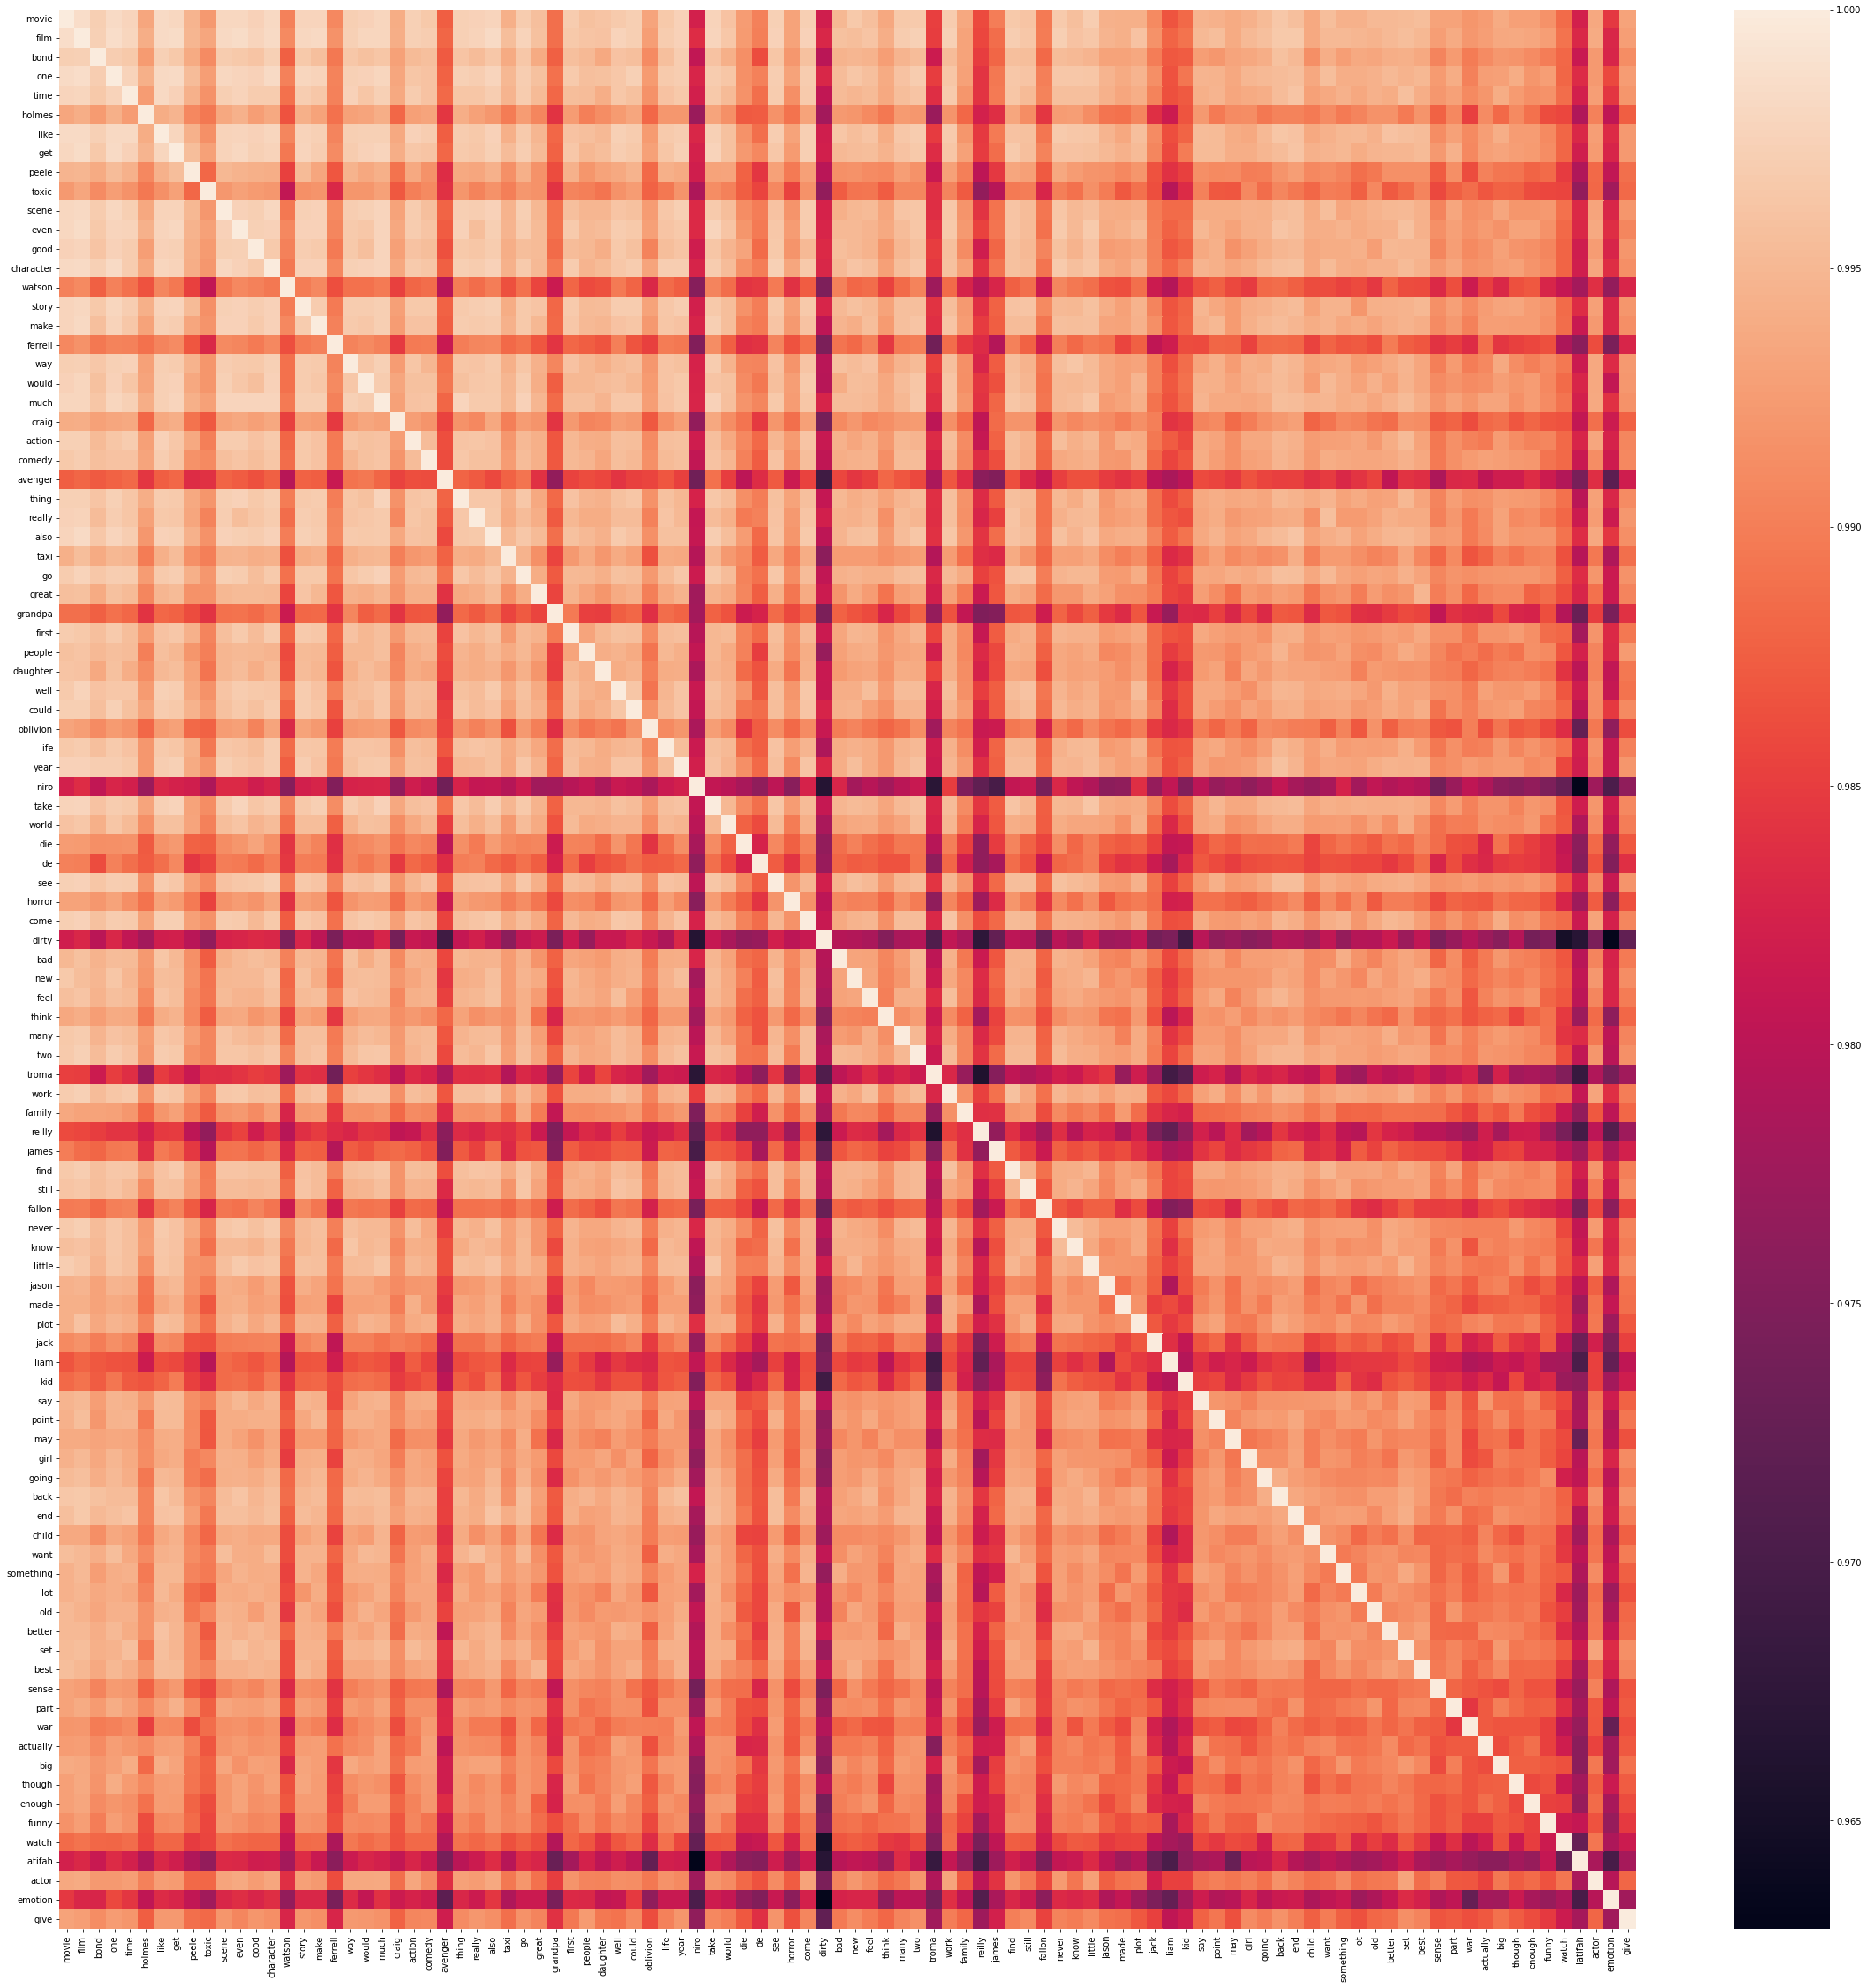

In [36]:
fig, ax = plt.subplots(figsize=(40, 40))

sns.heatmap(ax=ax, 
            data=similarities,
            xticklabels=top100_tfidf_word_vectors.index, 
            yticklabels=top100_tfidf_word_vectors.index)

## Doc2Vec

The [Doc2Vec model implementation](https://radimrehurek.com/gensim/models/doc2vec.html?highlight=doc2vec#module-gensim.models.doc2vec) in gensim uses a special TaggedDocument class of inputs to build the model.

In [37]:
documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(class_corpus.lemmatized_tokens)]

In [38]:
model_doc2vec = Doc2Vec(documents,
                        vector_size=100,
                        min_count=1,
                        workers=4)

We can now use this Doc2Vec model to infer vectors for all the documents in class corpus. The tokens are stored in the `TaggedDocument` instance as the `words` attribute.

In [39]:
model_doc2vec.infer_vector(documents[0].words)

array([ 0.4465494 , -0.46687767, -0.5379516 , -0.08632806, -0.2299982 ,
        0.3426532 ,  0.02754435, -0.5395712 , -0.2368765 , -0.14836282,
        0.02969033, -0.19251198, -0.13775162,  0.33293402,  0.19263193,
       -0.37429723,  0.3348381 ,  0.02005581,  0.01689204, -0.45000857,
       -0.16822407,  0.0421633 ,  0.03725457, -0.02573859,  0.4125267 ,
       -0.35398448, -0.13237548,  0.32731384, -0.58178383, -0.83436275,
       -0.549527  , -0.5383381 , -0.14319447, -0.0270801 ,  0.04824837,
        0.05009259, -0.5550714 , -0.28551573, -0.11822284,  0.5631194 ,
        0.27373776, -0.4685802 , -0.60595834,  0.09128272,  0.45168585,
        0.49646467, -0.14556503,  0.513231  , -0.29920778,  0.01612762,
       -0.39046377, -0.27841252,  0.05211382,  0.7259644 , -0.08668654,
       -0.0999964 ,  0.5329771 ,  0.5116469 , -0.16798034, -0.06372352,
        0.43927193, -0.28275508,  0.14178585,  0.4827762 , -0.39138153,
        0.1518936 ,  0.09929556,  0.02200039,  0.20250191, -0.02

In [40]:
doc2vec_df = pd.DataFrame()

for document in documents:
    vector = pd.DataFrame(model_doc2vec.infer_vector(document.words)).transpose()
    doc2vec_df = pd.concat([doc2vec_df, vector])

In [41]:
doc2vec_df.shape

(100, 100)

In [42]:
similarities = cosine_similarity(doc2vec_df, 
                                 doc2vec_df)

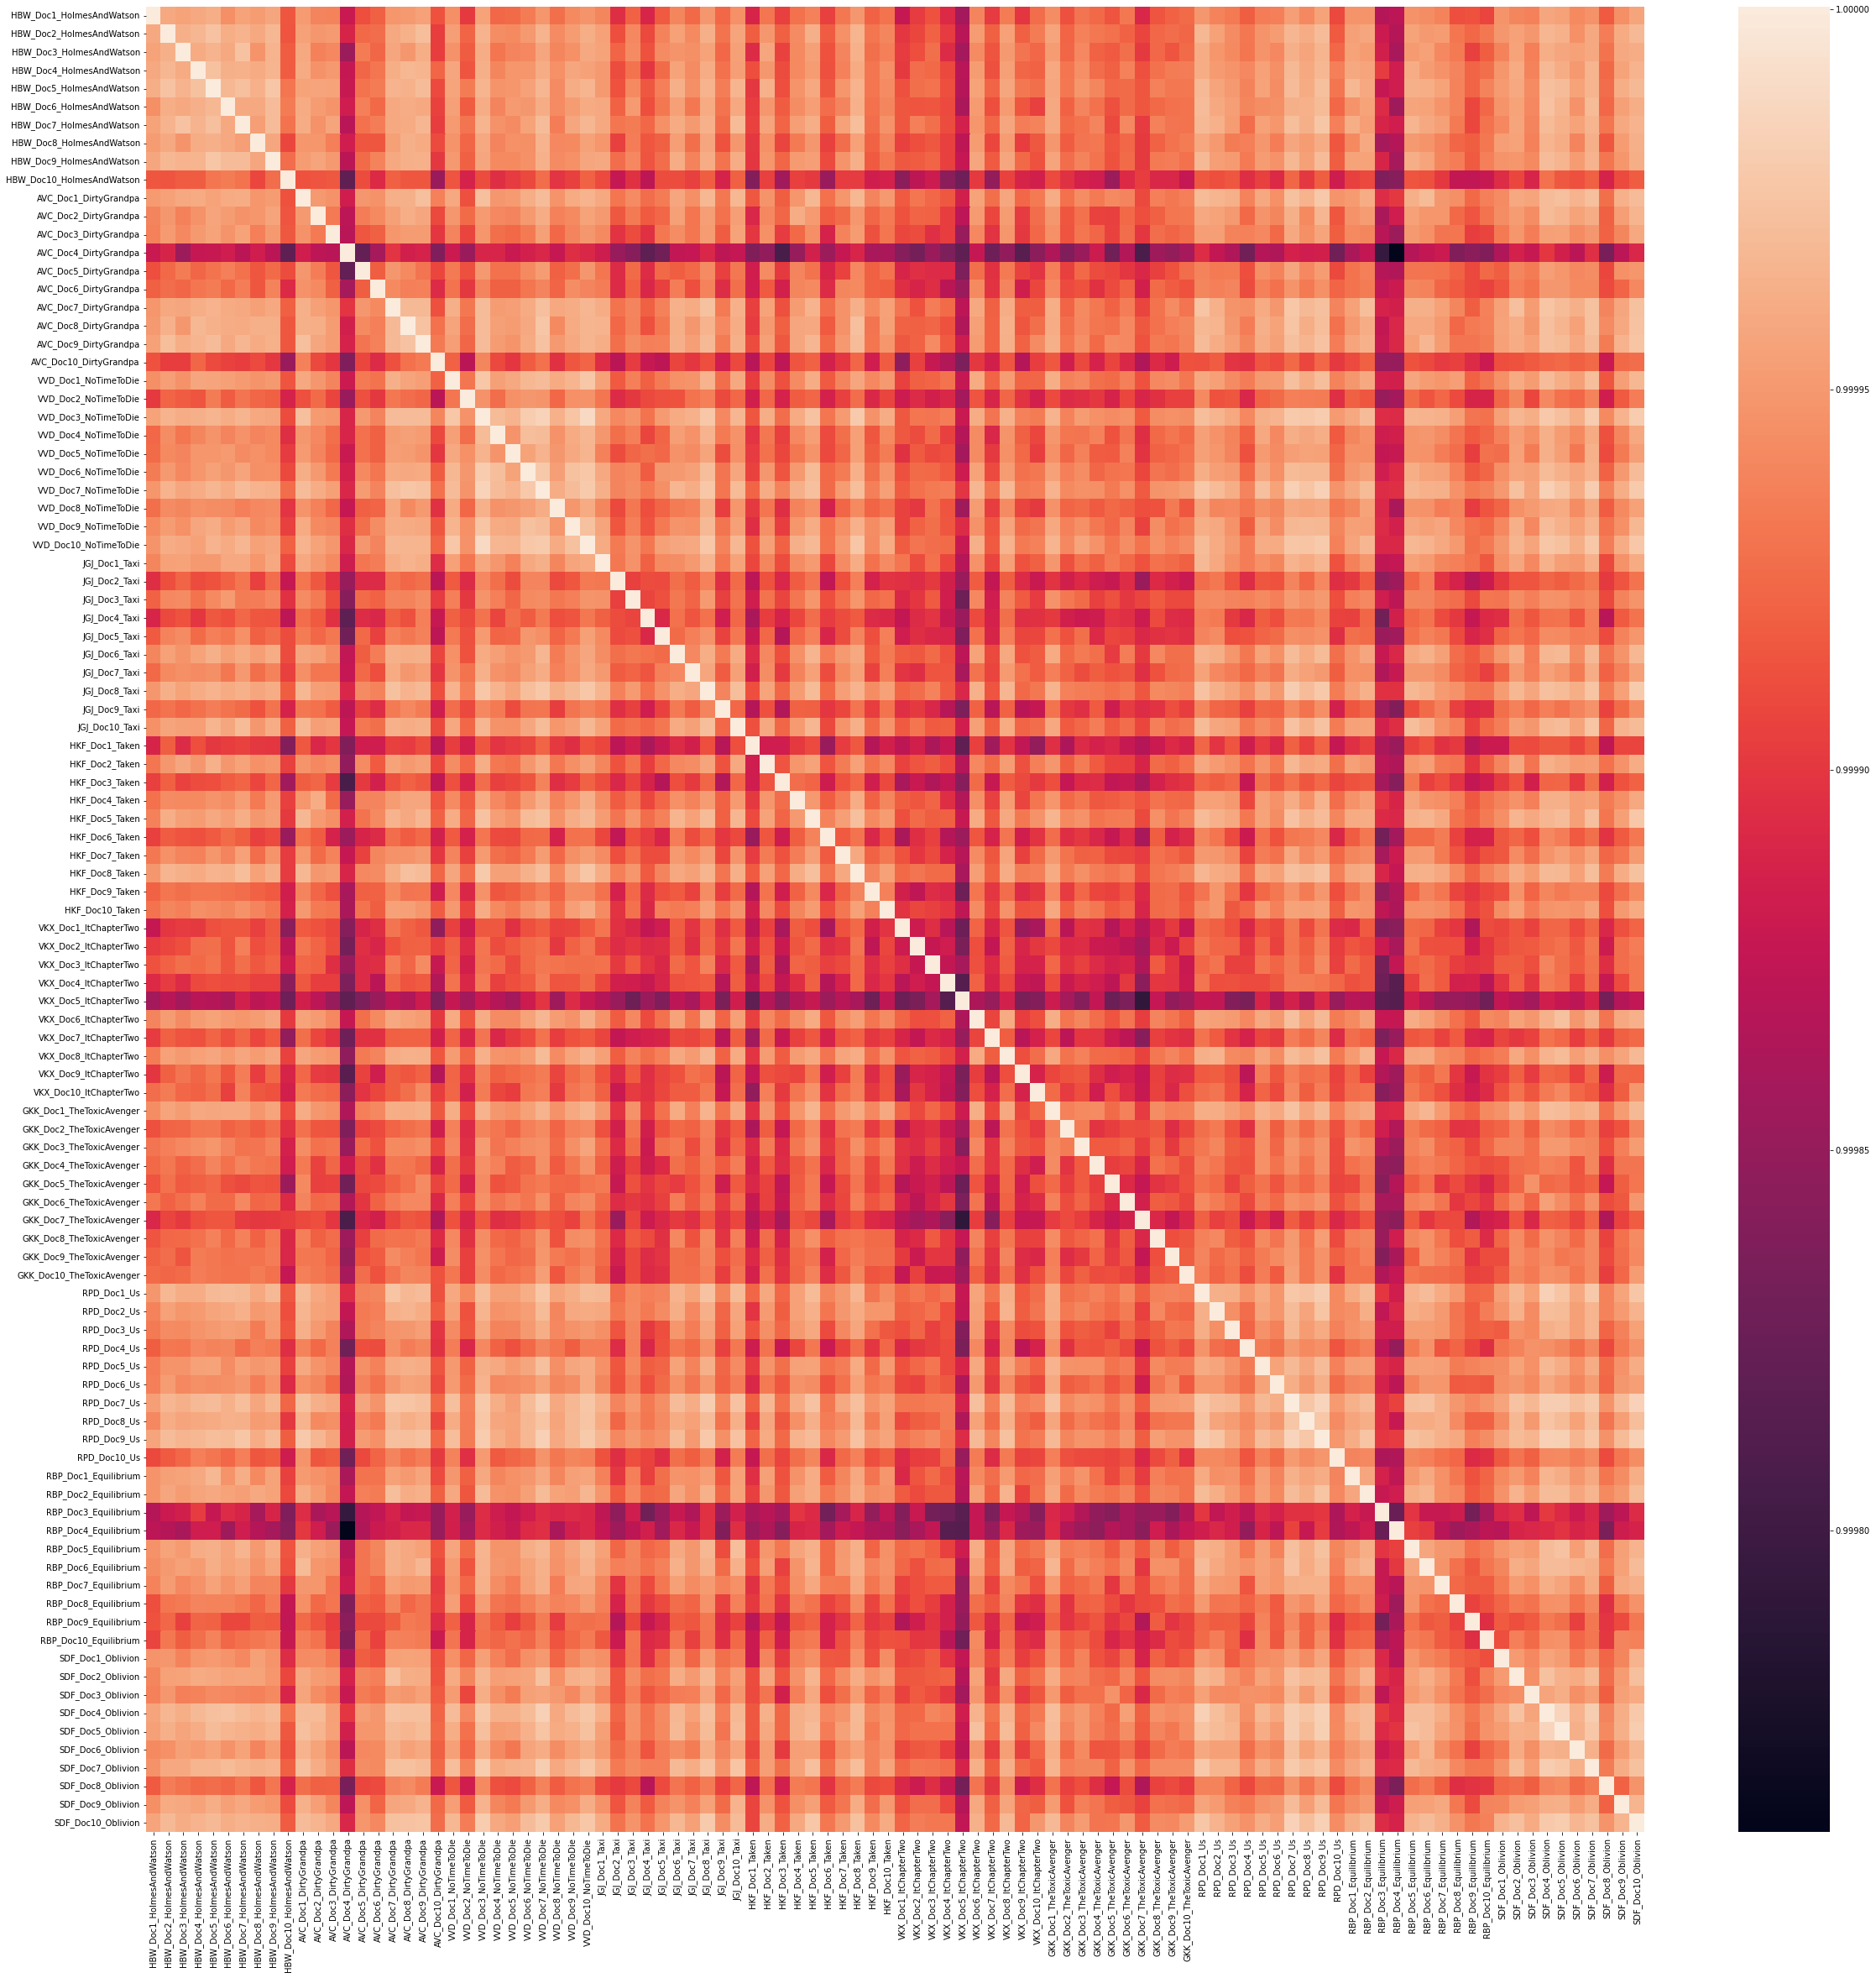

In [44]:
fig, ax = plt.subplots(figsize=(40, 40))

sns.heatmap(ax=ax, 
            data=similarities,
            xticklabels=class_corpus.DSI_Title, 
            yticklabels=class_corpus.DSI_Title)

# Summary

To execute each experiment:

1. Change the data wrangling method
2. Change the dimensionality of the embedding (not applicable for TF-IDF)

Suggested project structure ([Cookie Cutter Data Science](https://drivendata.github.io/cookiecutter-data-science/)):

```nohighlight
├── README.md          <- The top-level README for developers using this project.
├── data
│   ├── interim        <- Intermediate data that has been transformed.
│   ├── processed      <- The final, canonical data sets for modeling.
│   └── raw            <- The original, immutable data dump.
├── notebooks          <- Jupyter notebooks. Naming convention is a number (for ordering),
│                         the creator's initials, and a short `-` delimited description, e.g.
│                         `1.0-pkg-tf-idf-experiment1`.
│
├── references         <- Data dictionaries, manuals, and all other explanatory materials.
│
├── reports            <- Generated analysis as HTML, PDF, LaTeX, etc.
│   └── figures        <- Generated graphics and figures to be used in reporting
│
├── requirements.txt   <- The requirements file for reproducing the analysis environment, e.g.
│                         generated with `pip freeze > requirements.txt`
```